# Scenario 3 subtask 1: Estimate the True Number of Infections

**Background:** 10/2020 - 1/2021 in Greater Boston area. Predicting cases from wastewater potentially reports closer to the truth than testing.

**TASK 1:** Replicate the fitting excersize (A) in Section 3.2 of https://doi.org/10.1016/j.scitotenv.2022.159326. Fit $\lambda$, $\alpha$, and E(0).
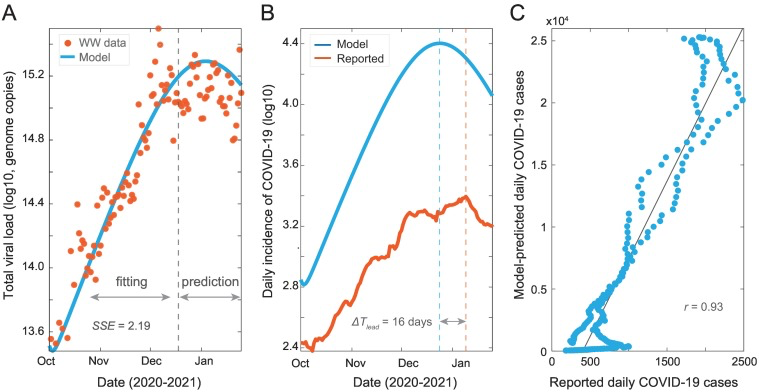

**Specifications:**
1. SEIR-V model
2. Data found in supplementary materials
3. Simplify wherever necessary (e.g. fixed $\beta$)

In [1]:
import os
import urllib.request, json 
import pandas as pd
from IPython.display import HTML
#from IPython import display
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_petri_model,
    setup_petri_model,
    sample
)
import numpy as np
from typing import Iterable
from pyciemss.utils.interface_utils import (
    assign_interventions_to_timepoints,
    interventions_and_sampled_params_to_interval,
    convert_to_output_format
)
from pyciemss.utils import get_tspan
from pyciemss.visuals import plots
import matplotlib.pyplot as plt
import torch
from torch import tensor

In [2]:
## Loading Utilities

COLORS=['red','green','blue','black','gold','purple','orangered']

def aggregate_results(samples_df, num_samples=1):
    QoIs = ["D_sol", "E_sol", "I_sol", "R_sol", "S_sol"]
    all_QoIs = {key: None for key in QoIs}
    for QoI in QoIs:
        # Aggregate results
        # TODO: After they introduce normalized models, remove normalization here.
        # /total_pop * 100
        # total_pop = 0
        # for val in QoIs:
        #     total_pop += samples_df[samples_df["sample_id"] == 0][val].to_numpy()[0]
        all_QoIs[QoI] = [samples_df[samples_df["sample_id"] == i][QoI].to_numpy() for i in range(num_samples)]
    return all_QoIs

def plotseird(t, S=None, E=None, I=None, R=None, D=None, L=None, R0=None, Alpha=None, CFR=None, ax=None):
    if ax is None:
        f, ax = plt.subplots(1,1,figsize=(10,4))
    N = S[0] + E[0] + I[0] + R[0] + D[0]
    if S is not None:
        ax.plot(t, (S/N)*100, 'b--', alpha=0.7, linewidth=2, label='Susceptible')
    if E is not None:
        ax.plot(t, (E/N)*100, 'y.', alpha=0.7, linewidth=2, label='Exposed')
    if I is not None:
        ax.plot(t, (I/N)*100, 'r', alpha=0.7, linewidth=2, label='Infected')
    if R is not None:
        ax.plot(t, (R/N)*100, 'g-.', alpha=0.7, linewidth=2, label='Recovered')

    if D is not None:
        ax.plot(t, D/N, 'k', alpha=0.7, linewidth=2, label='Dead')
        ax.plot(t, ((S+E+I+R+D)/N)*100, 'c:', alpha=0.7, linewidth=2, label='Total')
    else:
        ax.plot(t, ((S+E+I+R)/N)*100, 'c:', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Percentage of Population (%)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    if L is not None:
        plt.title("Lockdown after {} days".format(L))
    # plt.show()

    if R0 is not None or CFR is not None:
        f = plt.figure(figsize=(12,4))
    
    if R0 is not None:
        # sp1
        ax1 = f.add_subplot(121)
        ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

        ax1.set_xlabel('Time (days)')
        ax1.title.set_text('R_0 over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax1.yaxis.set_tick_params(length=0)
        ax1.xaxis.set_tick_params(length=0)
        ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    if Alpha is not None:
        # sp2
        ax2 = f.add_subplot(122)
        ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

        ax2.set_xlabel('Time (days)')
        ax2.title.set_text('fatality rate over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax2.yaxis.set_tick_params(length=0)
        ax2.xaxis.set_tick_params(length=0)
        ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax2.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    # plt.show()

# Add '?raw=true' at the end of the link to the file to get the rawgithubusercontent link.

def update_AMR(SEIRD_model_url, SEIRD_model_path):
    with urllib.request.urlopen(SEIRD_model_url) as url:
        json_object = json.load(url)
        with open(SEIRD_model_path, "w") as outfile:
            json.dump(json_object, outfile)

def change_model_parameters(filename, new_params):
    # new params = [(param, value), (param, value)]
    with open(filename, 'r') as f:
        model = json.load(f)
        # Change initial parameters
        for (param, value) in new_params:
            for idx in model["semantics"]["ode"]["parameters"]:
                if idx["id"] == param:
                    idx["value"] = value
    return model

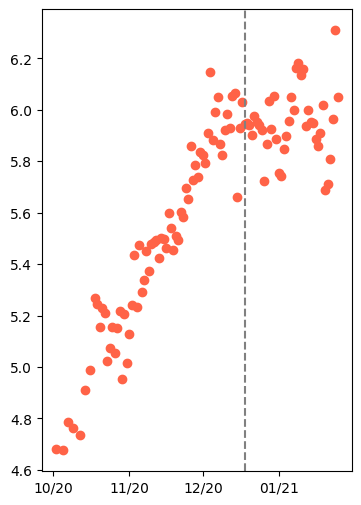

In [4]:
import matplotlib.dates as mdates
import datetime as dt

# Load Data
WW_data = pd.read_csv('data/Viralconcentration_DI_2020-2021.csv')
WW_data['Date'] = pd.to_datetime(WW_data['Date'], format='%m/%d/%y')
#display(WW_data)

# Plot
plt.figure(figsize=(4,6))
plt.scatter(WW_data.Date, WW_data['log_SARS-CoV-2'], color='tomato')
plt.axvline(dt.datetime(2020,12,18), linestyle='dashed', color='grey')

# Change x-axis Ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

In [72]:
dt.datetime(2021,1,25) - dt.datetime(2020,10,2)

datetime.timedelta(days=115)

In [14]:
change_model_parameters(SEIRV_model_path, [("beta", 4.49e7),("lambda",9.66e-8),("gamma",0.08)])

{'name': 'Scenario 3 base model',
 'schema': 'https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/petrinet_v0.5/petrinet/petrinet_schema.json',
 'schema_name': 'petrinet',
 'description': 'Scenario 3 base model',
 'model_version': '0.1',
 'properties': {},
 'model': {'states': [{'id': 'S',
    'name': 'S',
    'grounding': {'identifiers': {'ido': '0000514'}, 'modifiers': {}},
    'units': {'expression': 'person', 'expression_mathml': '<ci>person</ci>'}},
   {'id': 'I',
    'name': 'I',
    'grounding': {'identifiers': {'ido': '0000511'}, 'modifiers': {}},
    'units': {'expression': 'person', 'expression_mathml': '<ci>person</ci>'}},
   {'id': 'E',
    'name': 'E',
    'grounding': {'identifiers': {'apollosv': '0000154'}, 'modifiers': {}},
    'units': {'expression': 'person', 'expression_mathml': '<ci>person</ci>'}},
   {'id': 'V',
    'name': 'V',
    'grounding': {'identifiers': {'vido': '0001331'}, 'modifiers': {}},
    'units': {'expression': 'person',
     'expres

In [54]:
from mira.sources.askenet import model_from_url
from mira.modeling import Model

MIRA_model = model_from_url(SEIRV_model_url)
# print(MIRA_model,'\n')
print(MIRA_model.initials.keys(),'\n')
print(Model(MIRA_model).variables)

raw = load_petri_model(MIRA_model)
print(raw.G.variables)

dict_keys(['S', 'I', 'E', 'V']) 

{('S', ('identity', 'ido:0000514')): <mira.modeling.Variable object at 0x18b0d8160>, ('I', ('identity', 'ido:0000511')): <mira.modeling.Variable object at 0x18b0da8c0>, ('E', ('identity', 'apollosv:0000154')): <mira.modeling.Variable object at 0x18b0d9930>}
{('S', ('identity', 'ido:0000514')): <mira.modeling.Variable object at 0x18b397370>, ('I', ('identity', 'ido:0000511')): <mira.modeling.Variable object at 0x18b397f40>, ('E', ('identity', 'apollosv:0000154')): <mira.modeling.Variable object at 0x18b397d90>}


In [53]:
#dir(MIRA_model)
MIRA_model.initials

{'S': Initial(concept=Concept(name='S', display_name='S', description=None, identifiers={'ido': '0000514'}, context={}, units=Unit(expression=person)), value=2300000.0),
 'I': Initial(concept=Concept(name='I', display_name='I', description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=person)), value=0.0),
 'E': Initial(concept=Concept(name='E', display_name='E', description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=person)), value=1000.0),
 'V': Initial(concept=Concept(name='V', display_name='V', description=None, identifiers={'vido': '0001331'}, context={}, units=Unit(expression=person)), value=0.0)}

,timepoint_id,sample_id,lambda_param,k_param,delta_param,E_sol,I_sol,S_sol,timepoint_days
0,0,0,8.736219e-08,0.307657,0.131098,1000.000000,3.076569e-08,2300000.000,0.000000
1,1,0,8.736219e-08,0.307657,0.131098,970.004272,3.010160e+01,2299999.750,0.100000
2,2,0,8.736219e-08,0.307657,0.131098,941.500122,5.891735e+01,2300000.250,0.200000
3,3,0,8.736219e-08,0.307657,0.131098,914.417358,8.650854e+01,2299997.500,0.300000
4,4,0,8.736219e-08,0.307657,0.131098,888.688904,1.129336e+02,2299994.000,0.400000
...,...,...,...,...,...,...,...,...,...
7750,1546,4,8.787232e-08,0.347315,0.131161,38600.027344,1.111384e+05,1302402.000,154.600006
7751,1547,4,8.787232e-08,0.347315,0.131161,38531.148438,1.110210e+05,1301134.125,154.699997
7752,1548,4,8.787232e-08,0.347315,0.131161,38462.152344,1.109027e+05,1299866.000,154.800003
7753,1549,4,8.787232e-08,0.347315,0.131161,38392.968750,1.107835e+05,1298600.750,154.899994


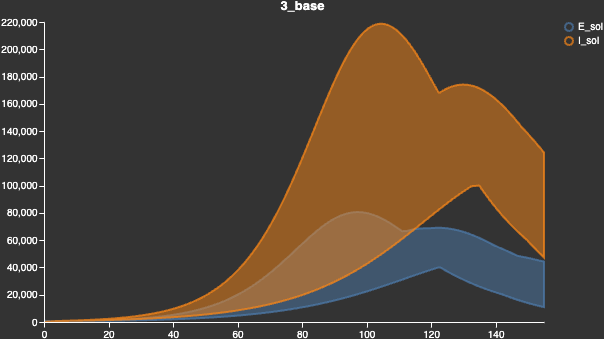

In [29]:
# Load Model
num_samples = 5
start_time = 0
end_time = 155 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

SEIRV_model_path = "data/eval_scenario3_base.json"
SEIRV_model_url = "https://raw.githubusercontent.com/indralab/mira/hackathon/notebooks/evaluation_2023.07/eval_scenario3_base.json"

raw = change_model_parameters(SEIRV_model_path, [("beta", 4.49e7),("lambda",9.66e-8),("gamma",0.08)])
#print(raw)

results_3_base = load_and_sample_petri_model(
        raw, num_samples, timepoints=timepoints, method="dopri5",
    visual_options={"title": "3_base", "subset":["I_sol", "E_sol"]}, time_unit="days")
display(results_3_base['data'])
#display(results_3_base)
plots.ipy_display(results_3_base["visual"])

In [62]:
import sympy
import itertools
from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel

person_units = lambda: Unit(expression=sympy.Symbol('person'))
virus_units = lambda: Unit(expression=sympy.Symbol('virus'))
virus_per_gram_units = lambda: Unit(expression=sympy.Symbol('virus')/sympy.Symbol('gram'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
gram_units = lambda: Unit(expression=sympy.Symbol('gram'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

# See Table 1 of the paper
c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '0000154'}),
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}),
    'V': Concept(name='V', units=person_units(), identifiers={'vido': '0001331'}),
}


parameters = {
    'gamma': Parameter(name='gamma', value=0.08, units=per_day_units()),
    'delta': Parameter(name='delta', value=1/8, units=per_day_units()),
    'alpha': Parameter(name='alpha', value=500, units=gram_units(),
                       distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 51,
                                                     'maximum': 796
                                                 })),
    'lambda': Parameter(name='lambda', value=9.66e-8, units=per_day_per_person_units()),
    'beta': Parameter(name='beta', value=4.49e7, units=virus_per_gram_units()),
    'k': Parameter(name='k', value=1/3, units=per_day_units()),
}

initials = {
    'S': Initial(concept=Concept(name='S'), value=2_300_000),
    'E': Initial(concept=Concept(name='E'), value=1000),
    'I': Initial(concept=Concept(name='I'), value=0),
    'V': Initial(concept=Concept(name='V'), value=0),
}

S, E, I, V, gamma, delta, alpha, lmbd, beta, k = \
    sympy.symbols('S E I V gamma delta alpha lambda beta k')

t1 = ControlledConversion(subject=c['S'],
                          outcome=c['E'],
                          controller=c['I'],
                          rate_law=S*I*lmbd)
t2 = NaturalConversion(subject=c['E'],
                       outcome=c['I'],
                       rate_law=k*E)
t3 = NaturalDegradation(subject=c['I'],
                       rate_law=delta*I)
t4 = ControlledProduction(outcome=c['V'],
                          controller=c['I'],
                          rate_law=alpha*beta*(1-gamma)*I)
templates = [t1, t2, t3, t4]
observables = {}
tm = TemplateModel(
    templates=templates,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Scenario 3 base model')
)
AskeNetPetriNetModel(Model(tm)).to_json_file('eval_scenario3_base.json')

In [60]:
Model(tm).variables

{('S', ('identity', 'ido:0000514')): <mira.modeling.Variable at 0x18b3976d0>,
 ('I', ('identity', 'ido:0000511')): <mira.modeling.Variable at 0x18b394a00>,
 ('E',
  ('identity', 'apollosv:0000154')): <mira.modeling.Variable at 0x18b3975b0>,
 ('V', ('identity', 'vido:0001331')): <mira.modeling.Variable at 0x18b397220>}

,timepoint_id,sample_id,lambda_param,k_param,delta_param,alpha_param,beta_param,gamma_param,"(('V', ('identity', 'vido:0001331')), ('I', ('identity', 'ido:0000511')), 'ControlledProduction', 'rate')_param",E_sol,I_sol,S_sol,V_sol,timepoint_days
0,0,0,9.755014e-08,0.334950,0.116166,515.038696,46442452.0,0.080150,0.052432,1000.000000,3.349496e-08,2.300000e+06,3.684863e-08,0.000000
1,1,0,9.755014e-08,0.334950,0.116166,515.038696,46442452.0,0.080150,0.052432,967.425781,3.275267e+01,2.300000e+06,3.630182e+10,0.100000
2,2,0,9.755014e-08,0.334950,0.116166,515.038696,46442452.0,0.080150,0.052432,936.631653,6.407226e+01,2.299998e+06,1.430772e+11,0.200000
3,3,0,9.755014e-08,0.334950,0.116166,515.038696,46442452.0,0.080150,0.052432,907.526917,9.403304e+01,2.299997e+06,3.172554e+11,0.300000
4,4,0,9.755014e-08,0.334950,0.116166,515.038696,46442452.0,0.080150,0.052432,880.028198,1.227056e+02,2.299994e+06,5.559250e+11,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7750,1546,4,1.006039e-07,0.329506,0.125945,579.613220,49289528.0,0.084523,0.276583,13746.326172,5.789104e+04,6.528668e+05,3.273802e+17,154.600006
7751,1547,4,1.006039e-07,0.329506,0.125945,579.613220,49289528.0,0.084523,0.276583,13673.798828,5.761545e+04,6.524878e+05,3.275313e+17,154.699997
7752,1548,4,1.006039e-07,0.329506,0.125945,579.613220,49289528.0,0.084523,0.276583,13601.619141,5.734090e+04,6.521108e+05,3.276817e+17,154.800003
7753,1549,4,1.006039e-07,0.329506,0.125945,579.613220,49289528.0,0.084523,0.276583,13529.808594,5.706747e+04,6.517359e+05,3.278315e+17,154.899994


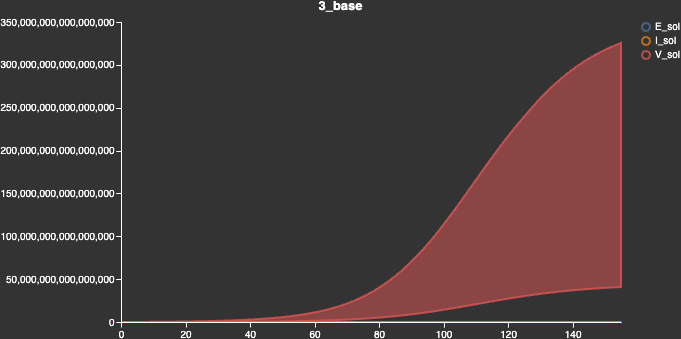

In [63]:
num_samples = 5
start_time = 0
end_time = 155 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

results_3_base = load_and_sample_petri_model(
        tm, num_samples, timepoints=timepoints, method="dopri5",
    visual_options={"title": "3_base", "subset":["I_sol", "E_sol", "V_sol"]}, time_unit="days")
display(results_3_base['data'])
#display(results_3_base)
plots.ipy_display(results_3_base["visual"])

**TASK 2:** Forecast from 12/18/2020 to 1/25/2021 and compare it to the figure's.

**TASK 3:** Repeat with uncertainty over the paper's parameters.

**BONUS:** Use temperature data during fitting to replicate figure 3A. Prove that it improves fit.
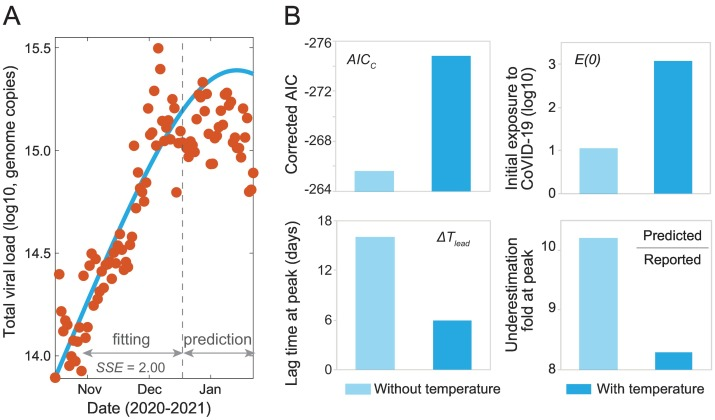